In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
import pandas as pd

In [30]:
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
!ls /content/gdrive/MyDrive/ML/

comments.csv  housing.data  housing.names  titanic.csv	wine.data  wine.names


In [10]:
df = pd.read_csv('../content/gdrive/MyDrive/ML/comments.csv')

In [12]:
df.shape

(14412, 2)

In [11]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [13]:
df['toxic'] = df['toxic'].apply(int)

In [15]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [18]:
for c in df[df['toxic'] == 1]['comment'].head(5):
    print(c)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [20]:
for c in df[df['toxic'] == 0]['comment'].head(5):
    print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [32]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [35]:
sentence_example = df.iloc[1]['comment']
tokens = word_tokenize(sentence_example, language='russian')
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words('russian')
tokens_without_stopwords_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language='russian')
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stopwords_and_punctuation]

In [36]:
print(sentence_example)
print(tokens)
print(tokens_without_punctuation)
print(tokens_without_stopwords_and_punctuation)
print(stemmed_tokens)

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисел', 'придума']


In [37]:
snowball = SnowballStemmer(language='russian')
russian_stop_words = stopwords.words('russian')

def tokenaize_sentence(sentence: str, remove_stop_words: bool=True):
    tokens = word_tokenize(sentence, language='russian')
    tokens = [i for i in tokens if i not in string.punctuation]

    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]

    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [44]:
train_df, test_df = train_test_split(df, test_size=500)

In [46]:
test_df.shape

(500, 2)

In [42]:
print(tokenaize_sentence(sentence_example))

['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисел', 'придума']


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenaize_sentence(x, remove_stop_words=True))

In [48]:
features = vectorizer.fit_transform(train_df['comment'])

In [49]:
model = LogisticRegression(random_state=0)

In [50]:
model.fit(features, train_df['toxic'])

LogisticRegression(random_state=0)

In [51]:
model.predict(features[0])

array([0])

In [52]:
train_df['comment'].iloc[0]

'Не получается уже перенести\n'

In [53]:
model_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenaize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=0))
]
)

In [54]:
model_pipeline.fit(train_df['comment'], train_df['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f3c5df4dcb0>)),
                ('model', LogisticRegression(random_state=0))])

In [58]:
model_pipeline.predict(['ты свинособака'])

array([1])

In [63]:
model_pipeline.predict(['захлопнись'])

array([0])

In [64]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict(test_df['comment']))

0.8813559322033898

In [65]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict(test_df['comment']))

0.6666666666666666

In [69]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df['toxic'], probas_pred=model_pipeline.predict_proba(test_df['comment'])[:,1])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


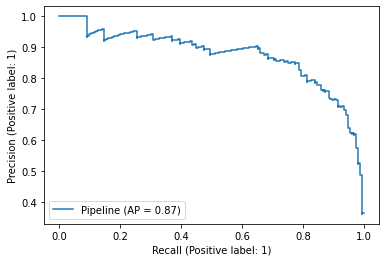

In [70]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df['comment'], y=test_df['toxic'])

In [71]:
np.where(prec > 0.95)

(array([389, 390, 407, 408, 409, 410, 417, 418, 419, 420, 421, 422, 423,
        424, 425, 426, 427, 428, 429, 430, 431]),)

In [72]:
thresholds[389]

0.7777409244959148

In [73]:
precision_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict_proba(test_df['comment'])[:,1] > thresholds[389])

0.9512195121951219

In [74]:
recall_score(y_true=test_df['toxic'], y_pred=model_pipeline.predict_proba(test_df['comment'])[:,1] > thresholds[389])

0.25

In [75]:
model_grid_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenaize_sentence(x, remove_stop_words=True))),
    ('model', 
     GridSearchCV(LogisticRegression(random_state=0),
                  param_grid={'C': [0.1, 1, 10.]},
                  cv=3,
                  verbose=4)
     )
])

In [76]:
model_grid_pipeline.fit(train_df['comment'], train_df['toxic'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.686 total time=   0.3s
[CV 2/3] END .............................C=0.1;, score=0.688 total time=   0.4s
[CV 3/3] END .............................C=0.1;, score=0.685 total time=   0.3s
[CV 1/3] END ...............................C=1;, score=0.832 total time=   0.6s
[CV 2/3] END ...............................C=1;, score=0.841 total time=   0.4s
[CV 3/3] END ...............................C=1;, score=0.838 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 1/3] END ............................C=10.0;, score=0.859 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 2/3] END ............................C=10.0;, score=0.863 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV 3/3] END ............................C=10.0;, score=0.868 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f3c5c515170>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [77]:
model_pipeline_c_10 = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=lambda x: tokenaize_sentence(x, remove_stop_words=True))),
    ('model', LogisticRegression(random_state=0, C=10.))
]
)

In [78]:
model_pipeline_c_10.fit(train_df['comment'], train_df['toxic'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7f3c5df17a70>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])